# Random Forest Model for Movie Revenue Prediction

This notebook implements a Random Forest Regressor to predict movie revenue based on features like budget, popularity, vote count, release year, and genres. It follows the same data preprocessing as the Linear Regression notebook but uses a Random Forest model with hyperparameter tuning and feature importance visualization.

## Possible Required Installs

Run the cell below if you encounter any issues (should take ~10 seconds):

In [1]:
%pip install pandas numpy scikit-learn matplotlib seaborn

## Required Imports

In [2]:
import pandas as pd
pd.options.mode.chained_assignment = None  # Suppress copy of slice warning
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

## Load and Prepare Data

Run this cell if you have sufficient memory.

In [3]:
# Load csv
movies_df = pd.read_csv('movies_metadata.csv', low_memory=False)

# Data prep function
def prepare_data(df):
    # Filter null revenue/budget values
    df['revenue'] = pd.to_numeric(df['revenue'], errors='coerce')
    df['budget'] = pd.to_numeric(df['budget'], errors='coerce')
    df = df[(df['revenue'] > 0) & (df['budget'] > 0)]
    
    # Log-transform popularity and budget
    df['popularity'] = pd.to_numeric(df['popularity'], errors='coerce')
    df['popularity'] = np.clip(df['popularity'].fillna(0), 1, 100)
    df['log_popularity'] = np.log1p(df['popularity'])
    
    df['vote_count'] = pd.to_numeric(df['vote_count'], errors='coerce')
    df['release_year'] = pd.to_datetime(df['release_date'], errors='coerce').dt.year
    
    # Convert genres to binary
    genres = ['Action', 'Comedy', 'Drama', 'Adventure']
    for genre in genres:
        df[f'genre_{genre}'] = df['genres'].str.contains(genre, case=False).astype(int)
    
    # Log-transform target and budget
    df['log_revenue'] = np.log1p(df['revenue'])
    df['log_budget'] = np.log1p(df['budget'])
    
    return df.dropna(subset=['log_revenue', 'log_budget', 'log_popularity', 'vote_count', 'release_year'])

## <h3> Feature Selection and Training </h3>

<p> Expect around a minute of runtime. </p>

In [10]:
# Prepare data
movies_df = prepare_data(movies_df)

# Define features and target
features = ['log_budget', 'log_popularity', 'vote_count', 'release_year', 
            'genre_Action', 'genre_Comedy', 'genre_Drama', 'genre_Adventure']
X = movies_df[features]
y = movies_df['log_revenue']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define preprocessing pipeline
numeric_features = ['log_budget', 'log_popularity', 'vote_count', 'release_year']
categorical_features = ['genre_Action', 'genre_Comedy', 'genre_Drama', 'genre_Adventure']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ])

# Define Random Forest pipeline
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Hyperparameter grid search
param_grid = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [10, 20, None],
    'regressor__max_features': ['auto', 'sqrt', 0.5]
}

grid_search = GridSearchCV(
    rf_pipeline,
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# Fit model
grid_search.fit(X_train, y_train)

# Best model
model = grid_search.best_estimator_

# Evaluate model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"R^2 Score: {r2:.4f}")

c:\Users\gemc\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
45 fits failed out of a total of 135.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\gemc\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\gemc\anaconda3\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\gemc\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 473, in fit
    self._final_estimator.fit(Xt

Best Parameters: {'regressor__max_depth': 10, 'regressor__max_features': 0.5, 'regressor__n_estimators': 200}
Mean Squared Error: 2.3211
R^2 Score: 0.6553


## Feature Importance Plot

C:\Users\gemc\AppData\Local\Temp\ipykernel_21076\1735424821.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


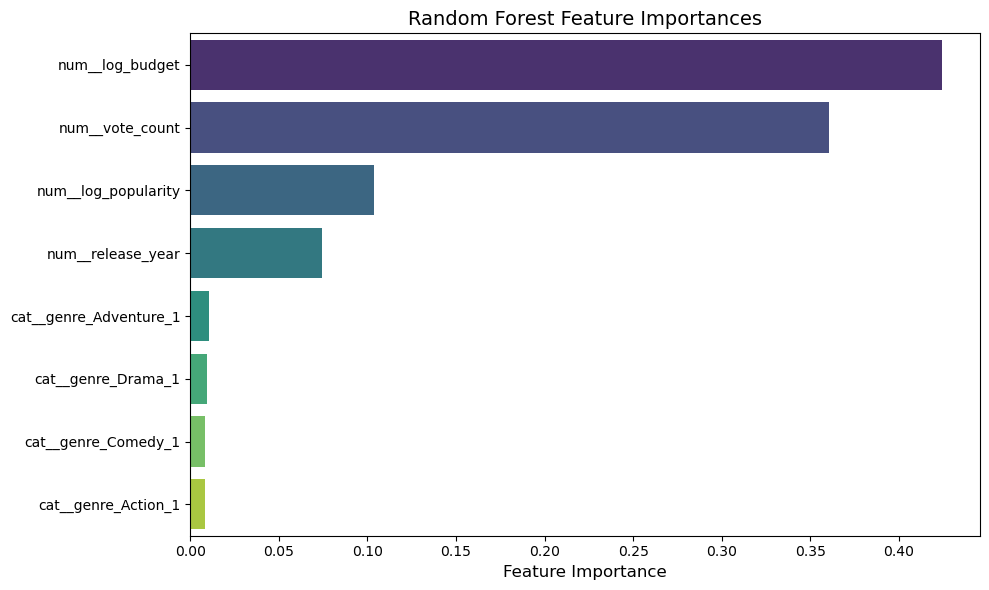

In [5]:
def plot_feature_importance(pipeline, feature_names=None):
    # Get model
    model = pipeline.named_steps['regressor']
    
    # Get feature importances
    importances = model.feature_importances_
    
    # Get preprocessor
    preprocessor = pipeline.named_steps['preprocessor']
    
    # Get feature names after preprocessing
    try:
        # For scikit-learn >= 1.0, use get_feature_names_out
        feature_names = preprocessor.get_feature_names_out()
    except AttributeError:
        # For older versions, manually construct feature names
        numeric_features = preprocessor.named_transformers_['num'].feature_names_in_
        ohe = preprocessor.named_transformers_['cat']
        categorical_features = ohe.get_feature_names_out(
            input_features=preprocessor.feature_names_in_[len(numeric_features):]
        )
        feature_names = list(numeric_features) + list(categorical_features)
    
    # Create DataFrame for plotting
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(
        x='Importance',
        y='Feature',
        data=importance_df,
        palette='viridis'
    )
    plt.title('Random Forest Feature Importances', fontsize=14)
    plt.xlabel('Feature Importance', fontsize=12)
    plt.ylabel('')
    plt.tight_layout()
    
    plt.savefig('../_layouts/rf_feature_importances.jpg')
    plt.show()
    
    return importance_df

# Get feature names from the fitted pipeline and plot feature importance
importance_df = plot_feature_importance(model)

## Prediction Function

In [6]:
def predict_movie_revenue(budget, popularity, vote_count=movies_df['vote_count'].mean(skipna=True), release_year=2000, 
                         is_action=False, is_comedy=False, is_drama=False, is_adventure=False):
    
    input_data = pd.DataFrame({
        'log_budget': [np.log1p(budget)],
        'log_popularity': [np.log1p(np.clip(popularity, 1, 100))],
        'vote_count': [vote_count],
        'release_year': [release_year],
        'genre_Action': [int(is_action)],
        'genre_Comedy': [int(is_comedy)],
        'genre_Drama': [int(is_drama)],
        'genre_Adventure': [int(is_adventure)]
    })
    
    # Predict in log form and convert back
    log_pred = model.predict(input_data)[0]
    return vote_count == movies_df['vote_count'].mean(skipna=True), np.expm1(log_pred)

## Test Prediction

Call the prediction function below:

In [7]:
# Test prediction (Avengers: Endgame example)
avg_vc_used, predicted_revenue = predict_movie_revenue(
    budget=356000000,
    popularity=100,
    # vote_count=4900,
    release_year=2019,
    is_action=True,
)

print(f"Unless specified, the average TMDb vote_count ({movies_df['vote_count'].mean(skipna=True):,.2f}) will be used.")
print(f"Average vote_count used: {avg_vc_used}")
print(f"Predicted Revenue: ${predicted_revenue:,.2f}")

Unless specified, the average TMDb vote_count (732.31) will be used.
Average vote_count used: True
Predicted Revenue: $170,545,125.20


In [8]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Generate predictions
y_pred = model.predict(X_test)

# Log scale statistics
print("Log scale statistics (Random Forest):")
print(f"R² Score: {r2_score(y_test, y_pred):.3f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}")
print(f"Mean Absolute Error: {(1 / len(y_test)) * np.sum(np.abs(y_test - y_pred)):.3f}")
print(f"Mean Average Precision Error: {(np.fabs(y_test - y_pred)/y_test)[y_test!=0].mean():.3f}")

Log scale statistics (Random Forest):
R² Score: 0.655
RMSE: 1.524
Mean Absolute Error: 1.003
Mean Average Precision Error: 0.087


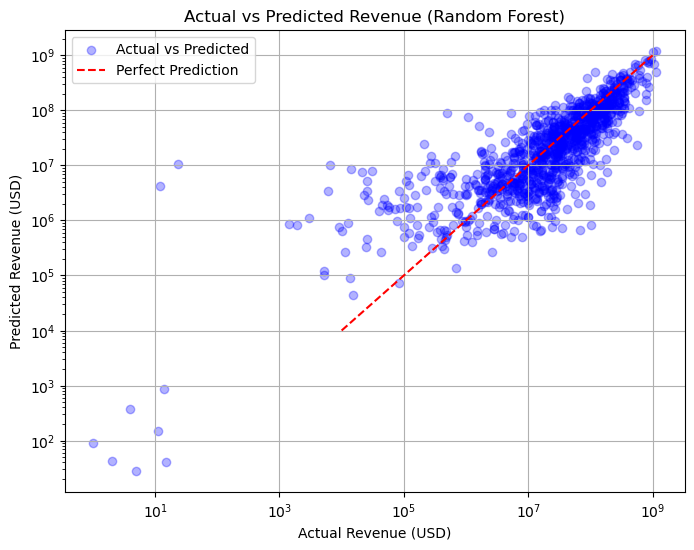

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Generate predictions (using X_test)
y_pred = model.predict(X_test)  # model is your trained Random Forest

# Convert log-transformed actual and predicted revenue to dollars
y_test_dollars = np.expm1(y_test)  # Convert log to dollars
y_pred_dollars = np.expm1(y_pred)  # Convert log to dollars

# Scatter plot of Actual vs Predicted Revenue (in USD, log scale)
plt.figure(figsize=(8, 6))
plt.scatter(y_test_dollars, y_pred_dollars, color='blue', alpha=0.3, label='Actual vs Predicted')
plt.plot([1e4, 1e9], [1e4, 1e9], color='red', linestyle='--', label='Perfect Prediction')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Actual Revenue (USD)')
plt.ylabel('Predicted Revenue (USD)')
plt.title('Actual vs Predicted Revenue (Random Forest)')
plt.legend()
plt.grid(True)
plt.savefig('../_layouts/actual_vs_predicted_revenue_rf.jpg')  # Save with RF-specific name
plt.show()